In [1]:
import numpy as np
df=np.load("/Users/rohitviswam/Downloads/CSI-02-0005/H_32T4R_30_1RB.npy")
data=df.reshape(2100,398,256) #dimension reduction
data.shape
feature_len=data.shape[-1]

In [2]:
# Part 1: Import Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

In [3]:

# transformer network is permutationally invariant: the order of the words doesnt matter so we add a positional encoder

class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_len=500):
        super(PositionalEncoder, self).__init__()
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Make sure x and pe are on the same device
        pe = self.pe[:, :x.size(1)].to(x.device)  # Ensure pe is on the same device as x
        return x + pe


In [4]:
# Part 3: Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, dim, heads, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=dim, num_heads=heads, dropout=dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(dim, 2 * dim),
            nn.ReLU(),
            nn.Linear(2 * dim, dim)
        )
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x + self.dropout(self.attention(x, x, x)[0])
        x = self.norm1(x)
        x = x + self.dropout(self.feed_forward(x))
        x = self.norm2(x)
        return x


In [5]:
# Part 4: Mini Transformer Model
class MiniTransformer(nn.Module):
    def __init__(self, feature_size, num_layers, heads, dropout=0.1):
        super(MiniTransformer, self).__init__()
        self.positional_encoder = PositionalEncoder(feature_size)
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(feature_size, heads, dropout) for _ in range(num_layers)
        ])
        self.output_layer = nn.Linear(feature_size, feature_size)  # Predicting the next timestep

    def forward(self, x):
        x = self.positional_encoder(x)
        for block in self.transformer_blocks:
            x = block(x)
        x = self.output_layer(x)
        return x

In [6]:

data_tensor = torch.tensor(data, dtype=torch.float32)

from torch.utils.data import random_split, DataLoader, TensorDataset

# Assuming data_tensor is already defined
total_samples = len(data_tensor)
# total_samples = len(data_tensor)


train_size = int(0.7 * total_samples)  # 70% for training
valid_size = int(0.15 * total_samples)  # 15% for validation
test_size = total_samples - train_size - valid_size  # Remaining 15% for testing

# Split the data into train, validation, and test sets
train_data, val_data, test_data = random_split(data_tensor, [train_size, valid_size, test_size])

# Now wrap these in TensorDataset (if needed) - only necessary if you're pairing with labels or need specific handling
train_dataset = TensorDataset(train_data.dataset[train_data.indices])
val_dataset = TensorDataset(val_data.dataset[val_data.indices])
test_dataset = TensorDataset(test_data.dataset[test_data.indices])


In [7]:
# Create Data Loaders for each set
# batch_size = data.shape[0]  # Define the batch size you'd like to use
batch_size=64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [8]:
len(train_dataset),len(test_dataset),len(val_dataset)

(1470, 315, 315)

In [23]:
from torch.cuda.amp import GradScaler, autocast

# Initialize your model, optimizer, and loss function
model = MiniTransformer(feature_size=feature_len, num_layers=2, heads=8, dropout=0.1)
# model.cuda()  # Move model to GPU

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# Initialize the scaler for mixed precision
scaler = GradScaler()

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for inputs in train_loader:
        inputs = inputs[0]  # Ensure data is on the GPU


        optimizer.zero_grad()

        # Run forward pass in mixed precision
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, inputs)

        # Scales loss. Calls backward() on scaled loss to create scaled gradients.
        scaler.scale(loss).backward()
        # scaler.step() first unscales the gradients of the optimizer's assigned params.

        # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
        # otherwise, optimizer.step() is skipped.
        scaler.step(optimizer)

        # Updates the scale for next iteration.
        scaler.update()

    # Evaluate on validation data
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs in val_loader:
            inputs = inputs[0]
            with autocast():
                outputs = model(inputs)
                val_loss += criterion(outputs, inputs).item()
    val_loss /= len(val_loader)
    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss:.4f}')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1, Validation Loss: 0.4634
Epoch 2, Validation Loss: 0.2432
Epoch 3, Validation Loss: 0.1337
Epoch 4, Validation Loss: 0.0960
Epoch 5, Validation Loss: 0.0765
Epoch 6, Validation Loss: 0.0647
Epoch 7, Validation Loss: 0.0556
Epoch 8, Validation Loss: 0.0497
Epoch 9, Validation Loss: 0.0451
Epoch 10, Validation Loss: 0.0415
Epoch 11, Validation Loss: 0.0380
Epoch 12, Validation Loss: 0.0366
Epoch 13, Validation Loss: 0.0340
Epoch 14, Validation Loss: 0.0316
Epoch 15, Validation Loss: 0.0317
Epoch 16, Validation Loss: 0.0281
Epoch 17, Validation Loss: 0.0267
Epoch 18, Validation Loss: 0.0263
Epoch 19, Validation Loss: 0.0247
Epoch 20, Validation Loss: 0.0235
Epoch 21, Validation Loss: 0.0223
Epoch 22, Validation Loss: 0.0214
Epoch 23, Validation Loss: 0.0204
Epoch 24, Validation Loss: 0.0208
Epoch 25, Validation Loss: 0.0195
Epoch 26, Validation Loss: 0.0185
Epoch 27, Validation Loss: 0.0187
Epoch 28, Validation Loss: 0.0173
Epoch 29, Validation Loss: 0.0167
Epoch 30, Validation Lo

In [24]:
from torch.nn.functional import mse_loss
from math import sqrt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Ensure the model is on the correct device

# Test loop
model.eval()
test_loss = 0
with torch.no_grad():
    for inputs in test_loader:
        
        inputs = inputs[0].to(device)  # Move inputs to the same device as the model
        outputs = model(inputs)
        test_loss += mse_loss(outputs, inputs).item()

test_loss /= len(test_loader)
print(f'Test MSE: {test_loss:.4f}')


Test MSE: 0.0104


In [25]:
import torch.nn.utils.prune as prune

# Define a simple pruning function that prunes the 'weight' parameter in each linear layer by 20%
def prune_model_custom(model, amount=0):
    for module in model.modules():
        if isinstance(module, torch.nn.Linear):
            prune.l1_unstructured(module, name="weight", amount=amount)

# Apply pruning
prune_model_custom(model)

# Check model to see the effect of pruning
print(model)

MiniTransformer(
  (positional_encoder): PositionalEncoder()
  (transformer_blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (feed_forward): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=256, bias=True)
      )
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (output_layer): Linear(in_features=256, out_features=256, bias=True)
)


cpu


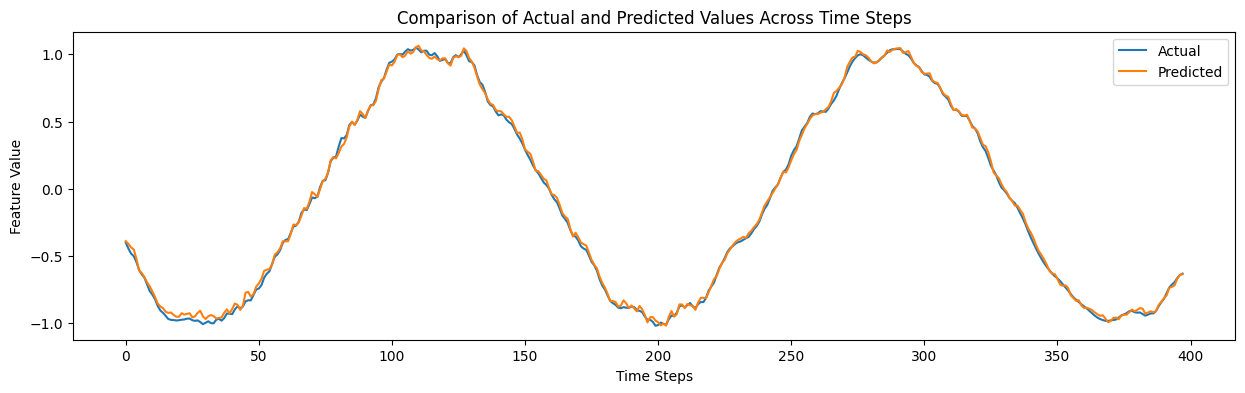

In [28]:
import matplotlib.pyplot as plt
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)  # Ensure the model is on the correct device
model.eval()

feature_index = 254
ue_num=60

with torch.no_grad():
    # cnt=0
    for inputs in test_loader:
        # print(cnt)
        inputs = inputs[0].to(device)  # Ensure inputs are moved to the device

        outputs = model(inputs)
        inputs = inputs.cpu()
        outputs = outputs.cpu()

        plt.figure(figsize=(15, 4))
        plt.plot(inputs[ue_num, :, feature_index].numpy()[:], label='Actual')  # inputs for first example, all time steps, specific feature
        plt.plot(outputs[ue_num, :, feature_index].numpy(), label='Predicted')  # outputs for first example, all time steps, specific feature
        plt.title('Comparison of Actual and Predicted Values Across Time Steps')
        plt.xlabel('Time Steps')
        plt.ylabel('Feature Value')
        plt.legend()
        plt.show()
        # cnt+=1
        break  # Only display the first batch

In [30]:
outputs

tensor([[[-0.2354, -0.6110,  0.4540,  ...,  1.0001,  0.4439,  0.4069],
         [ 0.2112,  0.1182,  0.6357,  ...,  1.6037, -0.3774,  1.2556],
         [-0.2327,  0.2712,  0.4772,  ...,  0.8345, -1.3137,  0.8240],
         ...,
         [-0.2148,  0.1067, -0.6705,  ..., -0.0293,  0.1537,  1.2686],
         [-1.2298,  0.0240, -0.8516,  ..., -0.1233, -0.6012,  0.3796],
         [-1.5307, -0.2431,  0.5304,  ...,  0.7357, -0.9749, -0.5900]],

        [[-0.8779,  0.6249,  0.6945,  ...,  0.9579, -0.1454, -0.9217],
         [-0.2342,  1.0891,  0.0447,  ...,  0.7743, -0.7705, -0.5511],
         [ 0.5507,  1.0305, -0.5869,  ...,  0.2017, -1.0281,  0.0564],
         ...,
         [ 0.8911, -0.1880, -1.0720,  ..., -0.5822, -0.2674,  0.8517],
         [ 0.7763, -0.7138, -0.5409,  ..., -0.7637,  0.5087,  0.8769],
         [ 0.2093, -0.9276,  0.3263,  ..., -0.5487,  1.0439,  0.4237]],

        [[ 0.4295,  0.5312,  1.1548,  ..., -1.1735, -0.9466, -0.0371],
         [ 0.7699,  0.1034,  0.8581,  ..., -0

In [31]:
inputs

tensor([[[-3.5656e-01, -6.7390e-01,  1.4016e-01,  ...,  1.1827e+00,
           4.8782e-01,  6.2968e-01],
         [-1.1989e-02, -6.8382e-02,  3.8016e-01,  ...,  1.8382e+00,
          -4.7238e-01,  1.5111e+00],
         [-3.1659e-01,  5.6020e-02,  3.6291e-01,  ...,  9.7887e-01,
          -1.3292e+00,  9.9354e-01],
         ...,
         [-2.7126e-01,  2.0730e-01, -7.2545e-01,  ..., -1.5543e-01,
           4.7557e-02,  1.3454e+00],
         [-1.5052e+00,  1.4049e-01, -1.0365e+00,  ...,  2.3622e-02,
          -7.5102e-01,  6.2293e-01],
         [-1.8092e+00, -2.4217e-01,  6.7031e-01,  ...,  9.5989e-01,
          -1.0549e+00, -4.3590e-01]],

        [[-9.8299e-01,  6.1236e-01,  7.6800e-01,  ...,  9.2767e-01,
          -2.0727e-01, -8.9184e-01],
         [-3.7564e-01,  1.0127e+00, -8.7664e-04,  ...,  7.2448e-01,
          -8.5486e-01, -5.3837e-01],
         [ 4.4294e-01,  9.8099e-01, -7.1329e-01,  ...,  1.7235e-01,
          -1.0830e+00,  5.1801e-02],
         ...,
         [ 8.8921e-01, -1